# Image Stitching

In this project I will implement an image stitching algorithm that automatically stitches multiple
images of a scene into a single panoramic image using image warping and homographies.

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from tqdm import tqdm
import time 
from scipy import ndimage
from scipy.spatial import distance
from numpy.linalg import inv
from skimage.transform import warp

## Taking panoramic pictures

Obtain your own images (5 images, $\mathrm{I_1}, \mathrm{I_2},\mathrm{I_3}, \mathrm{I_4}, \mathrm{I_5}$ ) by taking pictures of a scene in
dfferent views by rotating your camera. Be sure to maintain the same center of
projection while taking pictures and adequate overlap between neighboring views are
required. To avoid lens distortion, do not use wide-angle lens or mode of your camera.

- Resize your images into 256 x 256
- You need to convert color images to grey images (rgb2gray)

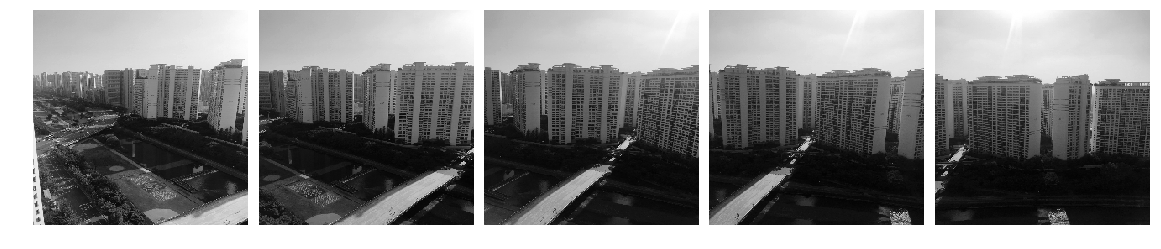

In [2]:
img_list = []
rgb_img_list = []
for i,file_name in enumerate(sorted(os.listdir("./data6"))) :
    image = cv2.imread("./data6/" + file_name)
    image = cv2.resize(image,(256,256))
    rgb_img_list.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_list.append(image)

fig = plt.figure(figsize=(20,20))
for i in range(len(img_list)):
    fig.add_subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(img_list[i],cmap="gray")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()    

## Feature Extraction

Detect feature points in each image.
- You can use SIFT feature and its MATLAB code vl_sift, or its OpenCV version (set the threshold to extract about 200-300 points in each image).
- You have to make the feature points be evenly distributed over each image and avoid multiple detections at the same point. (Think about how to get features extracted evenly across an image).

Find 250 features
Find 189 features
Find 200 features
Find 173 features
Find 177 features


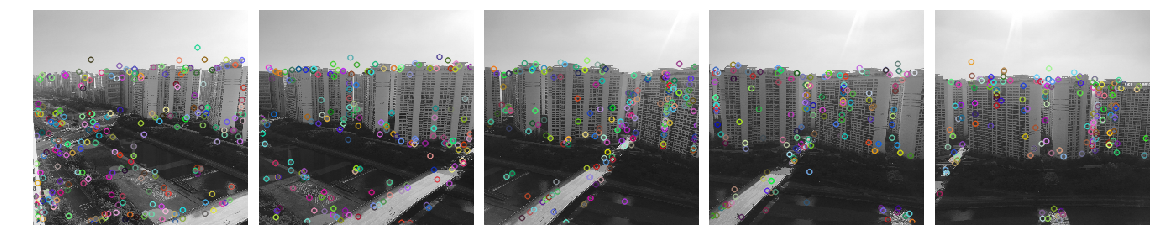

In [3]:
n_kp = 250
sift = cv2.xfeatures2d.SIFT_create(n_kp)
f_point_img = []
descriptors = []
kps = []
for img in img_list :
    kp, des = sift.detectAndCompute(img,None)
    img = cv2.drawKeypoints(img,kp,None) 
    f_point_img.append(img)
    descriptors.append(des)
    kps.append(kp)
    print(f'Find {len(kp)} features')
    
fig = plt.figure(figsize=(20,20))
for i in range(len(img_list)):
    fig.add_subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(f_point_img[i],cmap="gray")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()    

## Feature Matching 

Find the putative matches between images $\mathrm{I_i}$ and $\mathrm{I_{i+1}}$.
- For measuring the uniqueness of the correspondences, use the ratio of the distance between the best matching keypoint and the distance to the second best one. You can use the code vl_ubcmatch.
- For speed up the feature matching, use the kd-tree library such as ANN (http://www.cs.umd.edu/~mount/ANN/ ). Plot the detected key points and the correspondences between adjacent images
- Display the detected correspondences using lines or vectors overlaid on the images.

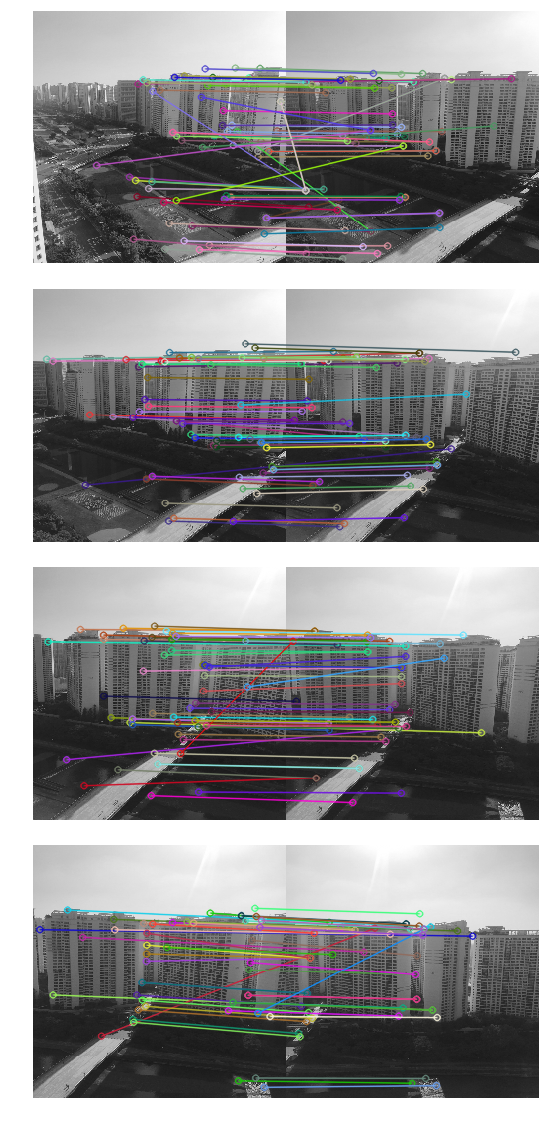

In [4]:
matching_img = []
bf = cv2.BFMatcher()

for i in range(len(img_list)-1):
    des1 = descriptors[i]
    des2 = descriptors[i+1]
    img1 = img_list[i]
    img2 = img_list[i+1]
    kp1 = kps[i]
    kp2 = kps[i+1]
    
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
    matching_img.append(img)
fig = plt.figure(figsize=(40,20))
for i in range(len(img_list)-1):
    fig.add_subplot(4, 1, i+1)
    plt.axis("off")
    plt.imshow(matching_img[i],cmap="gray")
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()    

## Homography Estimation using RANSAC
- Using the detected putative correspondences between $I_i$ and $I_j$, you can estimate the 3x3 Homography matrix Hij between two images using **RANSAC** and **DLT** method.
- Implement a homography estimation function using **RANSAC**, $\mathrm{H}_{\mathrm{ij}}=\mathrm{HbyRANSAC}\left(\mathrm{x}_{\mathrm{i}}, \mathrm{x}_{\mathrm{j}}\right)$ for two vectors of corresponding features in $\mathrm{I_i}$ and $\mathrm{I_j}$, respectively (four point features each).
- Use the symmetric transfer error for the distance measure $d_{\perp}=d\left(\mathbf{x}_{i}, \mathbf{H}^{-1} \mathbf{x}_{j}\right)^{2}+d\left(\mathbf{x}_{j}, \mathbf{H} \mathbf{x}_{i}\right)^{2}$
- Use DLT for determining H for a sampled 4 correspondences. For randomly sampling matches, you can use the _randperm_ or _randsample_ functions. The solution to the homogeneous least squares system $A h=0$ is obtained from the SVD of $A_{n \times 9}$ by the singular vector corresponding to the smallest singular value: $[U, S, V]=\operatorname{svd}(A) ; 
\quad X=V( :,$ end $)$
- Set the **RANSAC** parameter values: $t=1.25, p=0.99$
- Use the adaptive determination method for the # of samples N.
- Determine the homographies $H_{12},H_{23},H_{34},H_{45}$ using this function

In [5]:
"""
def GetSimilarityTransformation(X) :
    t = np.mean(X,0)
    u = 0
    for i in range(len(X)) :
        u += np.linalg.norm(X[i]-t)
    s = np.sqrt(2) / (u/len(X))
    T = np.eye(3) * s
    T[:,-1] = -t * s
    T[-1,-1] = 1
    return T 
    
def DLT(xi,xj,random_idx)
    A = np.zeros((8,9))
    X_i = []
    X_j = []
    for n,i in enumerate(random_idx) :
        Xi = np.asarray([xi[i][0],xi[i][1],1])
        Xj = np.asarray([xj[i][0],xj[i][1],1])
        X_i.append(Xi)
        X_j.append(Xj)
        A[2*n, :] = np.hstack([0*Xi,Xi,-Xj[1]*Xi])
        A[2*n+1, :] = np.hstack([Xi,0*Xi,-Xj[0]*Xi])  
    TXi = GetSimilarityTransformation(np.asarray(X_i))
    TXj = GetSimilarityTransformation(np.asarray(X_j))
    [_,D,V] = np.linalg.svd(A)
    h = V[-1]
    H = h.reshape((3,3))
    #H /= np.linalg.norm(H[2,2])
    H = np.matmul(np.matmul(np.linalg.pinv(TXj),H),TXi)
    return H
    
"""    
def DLT(xi,xj,random_idx) :
    A = np.zeros((8,9))
    xi = np.hstack((xi, np.ones((len(xi), 1))))
    xj = np.hstack((xj, np.ones((len(xj), 1))))
    Xi = xi[random_idx].T
    Xj = xj[random_idx].T
    for n in range(len(random_idx)) :
        A[2*n] = [-Xi[0][n], -Xi[1][n], -1, 0,0,0, Xj[0][n]*Xi[0][n], Xj[0][n]*Xi[1][n], Xj[0][n]*1]
        A[2*n+1] = [0,0,0, -Xi[0][n], -Xi[1][n], -1, Xj[1][n]*Xi[0][n], Xj[1][n]*Xi[1][n], Xj[1][n]*1]
    [_,D,V] = np.linalg.svd(A)
    H = V[-1].reshape((3,3))
    H /= H[2,2]
    return H
        

In [6]:
def AdaptiveDeterminantForRANSAC(xi,xj) :
    N = math.inf
    max_inliers = -1 
    max_dist = []
    max_H = None
    s = 4
    p = 0.99
    t = 5.0 #1.25
    sample_count = 0
    N = 1000#500
    while N > sample_count :
        random_idx = random.sample(list(range(len(xi))),4)
        H = DLT(xi,xj,random_idx)
        dist = []
        for i in range(len(xi)) :
            xi_ = np.hstack([xi[i],1])
            xj_ = np.hstack([xj[i],1])
            dist_ = math.pow(distance.euclidean(xi_,np.matmul(np.linalg.pinv(H),xj_)),2) + math.pow(distance.euclidean(xj_,np.matmul(H,xi_)),2)
            dist.append(dist_)
        num_inliers = np.count_nonzero(np.asarray(dist) < t) 
        
        if max_inliers < num_inliers :
            max_inliers = num_inliers
            max_H = H
            max_dist = dist
        total_num_points = len(xi)
        epsilon = 1- num_inliers / total_num_points
        #N = math.log(1-p) / (math.log(1-math.pow(1-epsilon,s)))
        sample_count += 1
    print(f'Find {max_inliers} inliers')    
    return max_H ,max_dist

In [7]:
# Compute homography between two images
def HbyRANSAC(des1,des2,kp1,kp2,matcher) :
    dist = []
    t=1.25
    p=0.99
    matches_kp = matcher.knnMatch(des1,des2,k=2)
    match_list = []
    for m,n in matches_kp :
        if m.distance < 0.7 * n.distance:
            match_list.append((m.trainIdx,m.queryIdx))
    xi = np.float32([kp1[k].pt for (_,k) in match_list])
    xj = np.float32([kp2[k].pt for (k,_) in match_list])
    Hij,max_dist = AdaptiveDeterminantForRANSAC(xi,xj)
    (H2, _) = cv2.findHomography(xi, xj, cv2.RANSAC,t)
    #print(Hij)
    #print("-------------")
    #print(H2)
    return Hij,H2,max_dist
    

In [8]:
Hij_list = []
Hij_inverse = []
H2_list = []
H2_inverse = []
matcher = cv2.BFMatcher()
max_dist_ = []
for i in range(4) : 
    des1 = descriptors[i]
    des2 = descriptors[i+1]
    kp1 = kps[i]
    kp2 = kps[i+1]
    #Hij_,H2_ = HbyRANSAC(des2,des1,kp2,kp1,matcher)
    Hij,H2,MD = HbyRANSAC(des1,des2,kp1,kp2,matcher)
    max_dist_.append(MD)
    Hij_list.append(Hij)
    H2_list.append(H2)
    #Hij_inverse.append(Hij_)
    #H2_inverse.append(H2_)


Find 11 inliers
Find 7 inliers
Find 21 inliers
Find 6 inliers


## Warping Images

- Implement a warping function that transform image $I_1$ to the other image $I_2$ using the homography $H_{12}$.
- Mosaic the five images by warping other images to the plane of the center image $I_3$. (Backward warping using inverse homography matrix is recommended for better visualization). You can use the _**maketform**_ and _**imtransform**_ functions.
- For color images, you can use the same homography for each color channel, and warp each RGB channel separately and then stack together to form the output

/home/hslim/.conda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


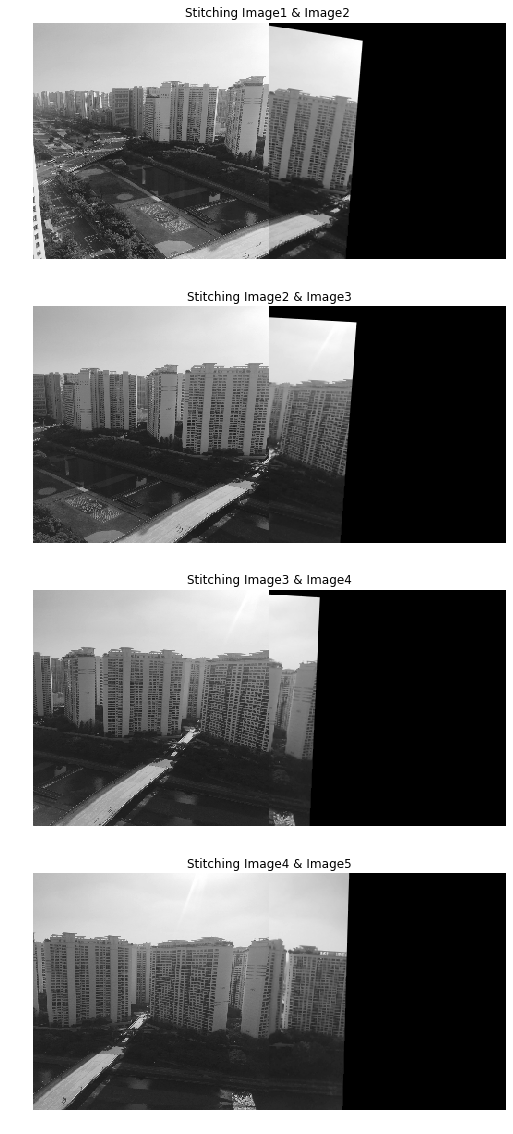

In [9]:
def WarpingFunction(I1,I2,Hij) :
    f_stitched = warp(I2, Hij,output_shape=(I1.shape[0],I1.shape[1]+I2.shape[1]))
    cv2.normalize(f_stitched,f_stitched,0,255,norm_type=cv2.NORM_MINMAX)
    f_stitched = f_stitched.astype(np.uint8)
    M, N = I1.shape[:2]
    f_stitched[:M,:N] = I1
    result = f_stitched

    return result


I12 = WarpingFunction(img_list[0],img_list[1],Hij_list[0])
I23 = WarpingFunction(img_list[1],img_list[2],Hij_list[1])
I34 = WarpingFunction(img_list[2],img_list[3],Hij_list[2])
I45 = WarpingFunction(img_list[3],img_list[4],Hij_list[3])
fig = plt.figure(figsize=(40,20))
fig.add_subplot(4, 1, 1)
plt.axis("off")
plt.title("Stitching Image1 & Image2 ")
plt.imshow(I12,cmap="gray")

fig.add_subplot(4,1,2)
plt.axis("off")
plt.title("Stitching Image2 & Image3")
plt.imshow(I23,cmap="gray")

fig.add_subplot(4,1,3)
plt.axis("off")
plt.title("Stitching Image3 & Image4")
plt.imshow(I34,cmap="gray")
fig.add_subplot(4,1,3)

fig.add_subplot(4,1,4)
plt.axis("off")
plt.title("Stitching Image4 & Image5")
plt.imshow(I45,cmap="gray")

plt.show()

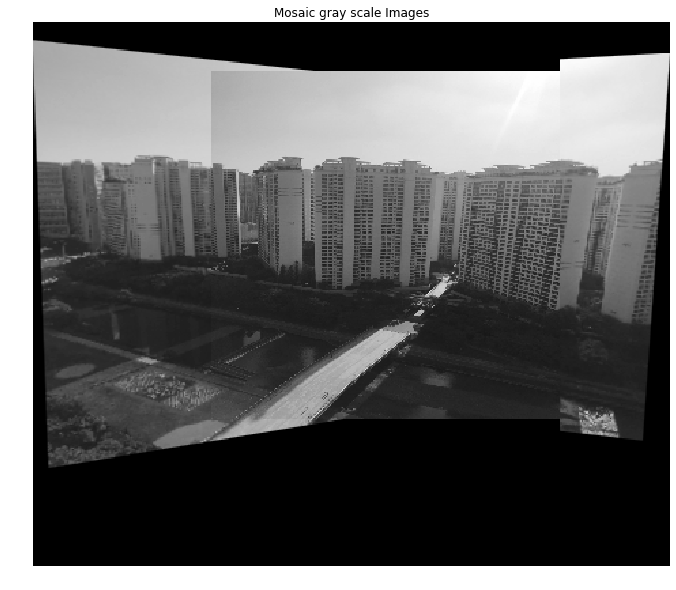

In [30]:
def get_minmax(final_shape) :
    [xmin, ymin] = np.int32(final_shape.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(final_shape.max(axis=0).ravel() + 0.5)
    return xmin,ymin,xmax,ymax

def left_mosaic(img_list,ctr,ctr_img,bd,ba,Hij_list):
    I2 = img_list[0]
    for i in range(ctr):
        I1 = img_list[i+1]
        if i == 0:
            w1,h1 = I1.shape[:2]
            w2,h2 = I2.shape[:2]
            I1_shape = np.float32([[0, 0], [0, I1.shape[0]], [I1.shape[0],I1.shape[1]], [I1.shape[1], 0]]).reshape(-1, 1, 2)
            I2_shape = np.float32([[0, 0], [0, I2.shape[0]], [I2.shape[0],I2.shape[1]], [I2.shape[1], 0]]).reshape(-1, 1, 2)

            I2shape = cv2.perspectiveTransform(I2_shape, Hij_list[i])            
        else:
            w1,h1 = I1.shape[:2]
            w2,h2 = I2.shape[:2]
            I1_shape = np.float32([[0, 0], [0, I1.shape[0]], [I1.shape[0],I1.shape[1]], [I1.shape[1], 0]]).reshape(-1, 1, 2)
            I2_shape = np.float32([[0, 0], [0, I2.shape[0]], [I2.shape[0],I2.shape[1]], [I2.shape[1], 0]]).reshape(-1, 1, 2)

            I2_shape = cv2.perspectiveTransform(I2_shape,ba.dot(Hij_list[i]))
        final_shape = np.concatenate((I1_shape, I2_shape), axis = 0)
        xmin,ymin,xmax,ymax = get_minmax(final_shape)

        dist = [-xmin,-ymin]
        distarray = np.array([[1, 0, dist[0]],[0, 1, dist[1]],[0, 0, 1]]) 
        
        left_img = cv2.warpPerspective(I2, distarray.dot(Hij_list[i]), (xmax-xmin+3, ymax-ymin))
        dist = [-xmin + bd[0], -ymin + bd[1]]
        left_img[dist[1]:I1.shape[0]+dist[1],dist[0]:I1.shape[1]+dist[0]] = I1
        bd = dist
        ba = distarray
        left_img = left_img[:, :I1.shape[1]+dist[0]]
        I2 = left_img[:, :I1.shape[1]+dist[0]]
    return ba,bd,left_img

def right_mosaic(img_n,img_list,ctr,ctr_img,bdd,baa,Hij_list) :
    I2 = img_list[img_n-1]
    for i in range(img_n-1, ctr, -1):
        I1 = img_list[i-1]
        ht = np.linalg.inv(Hij_list[i-1])
        if i == img_n-1:
            w1,h1 = I1.shape[:2]
            w2,h2 = I2.shape[:2]
            I1_shape = np.float32([[0, 0], [0, I1.shape[0]], [I1.shape[0],I1.shape[1]], [I1.shape[1], 0]]).reshape(-1, 1, 2)
            I2_shape = np.float32([[0, 0], [0, I2.shape[0]], [I2.shape[0],I2.shape[1]], [I2.shape[1], 0]]).reshape(-1, 1, 2)
            I2shape = cv2.perspectiveTransform(I2_shape, ht)            
        else:
            w1,h1 = I1.shape[:2]
            w2,h2 = I2.shape[:2]
            I1_shape = np.float32([[0, 0], [0, I1.shape[0]], [I1.shape[0],I1.shape[1]], [I1.shape[1], 0]]).reshape(-1, 1, 2)
            I2_shape = np.float32([[0, 0], [0, I2.shape[0]], [I2.shape[0],I2.shape[1]], [I2.shape[1], 0]]).reshape(-1, 1, 2)
            I2_shape = cv2.perspectiveTransform(I2_shape, baa.dot(ht))            

        final_shape = np.concatenate((I1_shape, I2_shape), axis = 0)
        xmin,ymin,xmax,ymax = get_minmax(final_shape)

        dist = [-xmin,-ymin]
        distarray = np.array([[1, 0, dist[0]],[0, 1, dist[1]],[0, 0, 1]]) 
        
        right_img = cv2.warpPerspective(I2, distarray.dot(ht),(xmax-xmin, ymax-ymin))
        dist = [-xmin + bdd[0], -ymin + bdd[1]]
        
        right_img[dist[1]:I1.shape[0]+dist[1],dist[0]:I1.shape[1]+dist[0]] = I1
        
        bdd = dist
        baa = distarray
        I2 = right_img
    return baa,bdd,right_img

def left_right_mosaic(ba,bd,left_img,baa,bdd,right_img,ctr_img) :
    mosaic = np.zeros((max(left_img.shape[0], right_img.shape[0])+bd[0], left_img.shape[1] + right_img.shape[1] - ctr_img.shape[1]))
    mosaic[bd[1]:right_img.shape[0]+bd[1], 
            bd[0]:right_img.shape[1]+bd[0]] = right_img
    mosaic[bdd[1]:bdd[1]+left_img.shape[0], :left_img.shape[1]] = left_img[:, :]
    return mosaic[:400, :]

def image_mosaic(img_list, Hij_list):
    ctr = int(np.ceil(len(img_list)/2)-1)
    img_n = len(img_list)
    ctr_img = img_list[ctr].copy()
    bd,bdd = [0, 0],[0,0]
    ba,baa = None,None

    ba,bd,left_img = left_mosaic(img_list,ctr,ctr_img,bd,ba,Hij_list)
    baa,bdd,right_img = right_mosaic(img_n,img_list,ctr,ctr_img,bdd,baa,Hij_list)

    return left_right_mosaic(ba,bd,left_img,baa,bdd,right_img,ctr_img)

result = image_mosaic(img_list, H2_list)
fig = plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Mosaic gray scale Images")
plt.imshow(result, cmap='gray')
plt.show()

# Result image
- Report the final homography estimation results and the total symmetric transfer error for each $H$.
- Display the intermediate pairwise matching results, and the final mosaic image.
- Discuss any issues or artifacts that may be evident in your output

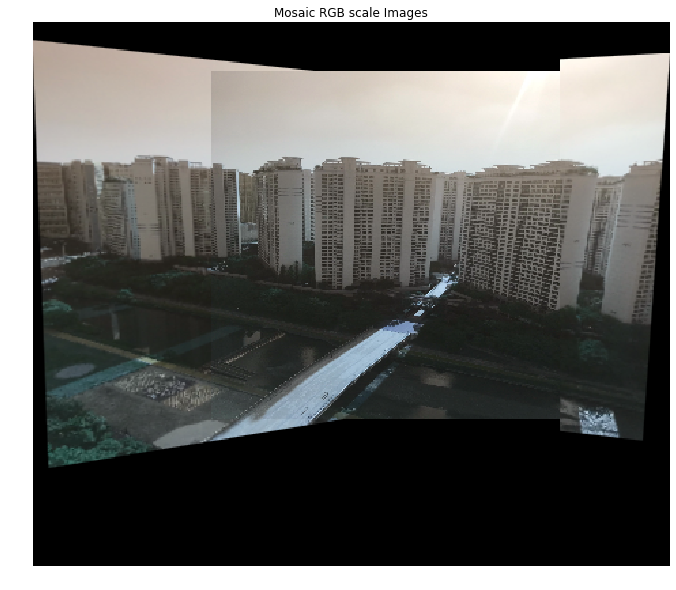

In [31]:
rgb_img_list = np.array(rgb_img_list)
R_img = image_mosaic(rgb_img_list[:, :, :, 2], H2_list)
G_img = image_mosaic(rgb_img_list[:, :, :, 1], H2_list)
B_img = image_mosaic(rgb_img_list[:, :, :, 0], H2_list)

result_image = np.stack((B_img, G_img, R_img), axis=2)
cv2.normalize(result_image, result_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
result_image = result_image.astype(np.uint8)
fig = plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Mosaic RGB scale Images")
plt.imshow(result_image, cmap='gray')
plt.show()

In [15]:
for i in range(4) : 
    print("Total symmetric transfer error for H%d%d : %d"%(i+1,i+2,np.sum(np.asarray(max_dist_[i]))))

Total symmetric transfer error for H12 : 97084
Total symmetric transfer error for H23 : 2261
Total symmetric transfer error for H34 : 66869
Total symmetric transfer error for H45 : 210631
